### Setup the Seurat objects

In [1]:
library(Seurat)
library(SeuratData)
library(patchwork)

── Installed datasets ───────────────────────────────────── SeuratData v0.2.1 ──

✔ hcabm40k 3.0.0                        


────────────────────────────────────── Key ─────────────────────────────────────

✔ Dataset loaded successfully
❯ Dataset built with a newer version of Seurat than installed
❓ Unknown version of Seurat installed




In [2]:
# install dataset
InstallData("ifnb")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
# load dataset
LoadData("ifnb")

# split the dataset into a list of two seurat objects (stim and CTRL)
ifnb.list <- SplitObject(ifnb, split.by = "stim")

# normalize and identify variable features for each dataset independently
ifnb.list <- lapply(X = ifnb.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

# select features that are repeatedly variable across datasets for integration
features <- SelectIntegrationFeatures(object.list = ifnb.list)

An object of class Seurat 
14053 features across 13999 samples within 1 assay 
Active assay: RNA (14053 features, 0 variable features)

### Perform integration

In [4]:
immune.anchors <- FindIntegrationAnchors(object.list = ifnb.list, anchor.features = features)

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 16407 anchors

Filtering anchors

	Retained 6750 anchors

Extracting within-dataset neighbors



In [5]:
# this command creates an 'integrated' data assay
immune.combined <- IntegrateData(anchorset = immune.anchors)

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
“Adding a command log without an assay associated with it”


### Perform an integrated analysis

> **Note: In order to use singlecellVR, users need to use at least 3 components for umap**

In [6]:
# specify that we will perform downstream analysis on the corrected data note that the
# original unmodified data still resides in the 'RNA' assay
DefaultAssay(immune.combined) <- "integrated"

# Run the standard workflow for visualization and clustering
immune.combined <- ScaleData(immune.combined, verbose = FALSE)
immune.combined <- RunPCA(immune.combined, npcs = 30, verbose = FALSE)
immune.combined <- RunUMAP(immune.combined, reduction = "pca", dims = 1:30, n.components = 3) #set n.components to 3
immune.combined <- FindNeighbors(immune.combined, reduction = "pca", dims = 1:30)
immune.combined <- FindClusters(immune.combined, resolution = 0.5)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
10:48:48 UMAP embedding parameters a = 0.9922 b = 1.112

10:48:48 Read 13999 rows and found 30 numeric columns

10:48:48 Using Annoy for neighbor search, n_neighbors = 30

10:48:48 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

10:48:51 Writing NN index file to temp file /var/folders/0f/sj3b57rj3nvfztwg4njsv6nc0000gp/T//RtmpdPX7bU/file7ee57b354c21

10:48:51 Searching Annoy index using 1 thread, search_k = 3000

10:48:55 Annoy recall = 100%

10:48:56 Commencing smooth kNN distance calibr

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13999
Number of edges: 580804

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9047
Number of communities: 14
Elapsed time: 2 seconds


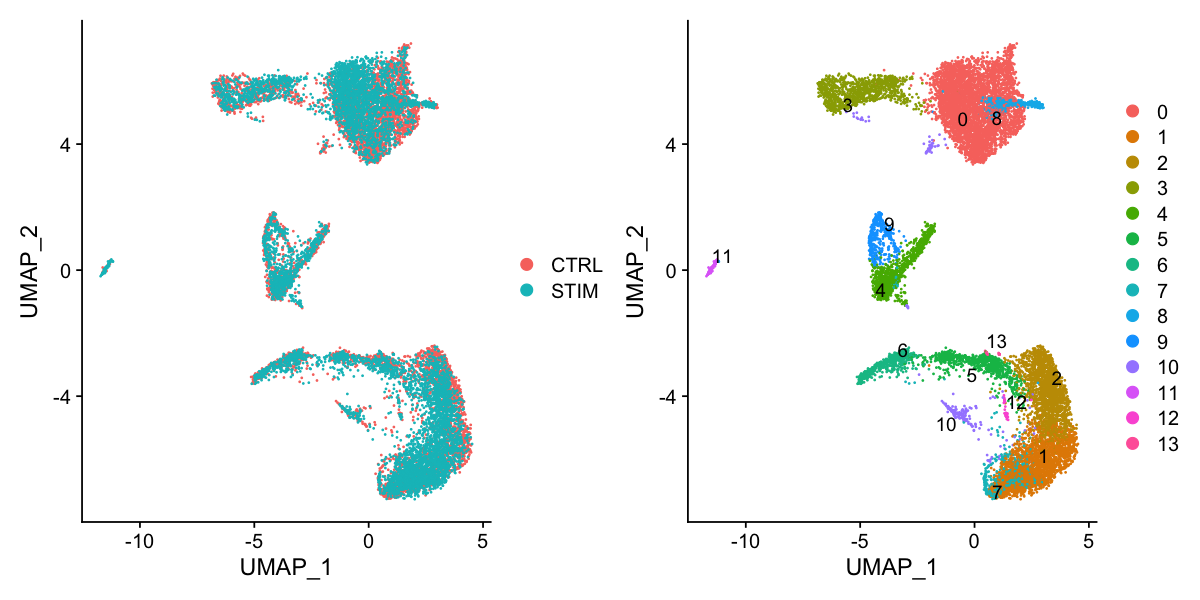

In [8]:
# Visualization
options(repr.plot.width=10, repr.plot.height=5)
p1 <- DimPlot(immune.combined, reduction = "umap", group.by = "stim")
p2 <- DimPlot(immune.combined, reduction = "umap", label = TRUE, repel = TRUE)
p1 + p2

#### This step is necessary in order to avoid the conversion issue later. See https://github.com/theislab/scanpy/issues/598

In [12]:
immune.combined@graphs <- list()

In [13]:
immune.combined.loom <- as.loom(immune.combined, filename = "./seurat_integration_result/seurat3d_integration.loom", verbose = FALSE)
immune.combined.loom

Transposing input data: loom file will show input columns (cells) as rows and input rows (features) as columns

This is to maintain compatibility with other loom tools

Adding: CellID

Adding: Gene

Adding: Selected

Adding: orig_ident

Adding: nCount_RNA

Adding: nFeature_RNA

Adding: stim

Adding: seurat_annotations

Adding: integrated_snn_res_0_5

Adding: seurat_clusters

Adding: ClusterID

Adding: ClusterName



Class: loom
Filename: /Users/huidong/Projects/SinglecellVR/seurat3d_integration/seurat_integration_result/seurat3d_integration.loom
Access type: H5F_ACC_RDWR
Attributes: version, chunks, LOOM_SPEC_VERSION, assay, last_modified
Listing:
       name    obj_type dataset.dims dataset.type_class
  col_attrs   H5I_GROUP         <NA>               <NA>
 col_graphs   H5I_GROUP         <NA>               <NA>
     layers   H5I_GROUP         <NA>               <NA>
     matrix H5I_DATASET 13999 x 2000          H5T_FLOAT
  row_attrs   H5I_GROUP         <NA>               <NA>
 row_graphs   H5I_GROUP         <NA>               <NA>

In [15]:
immune.combined.loom$close_all()